In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from src.test_hmm import compare_one, compare_transition_matrix

hmmlearn
[[0.32980949 0.67019051]
 [0.08873758 0.91126242]]
parallel
[[0.32980949 0.67019051]
 [0.08873758 0.91126242]]
gradient
[[0.30151214 0.69848786]
 [0.06371359 0.93628641]]
diff
[[1.11022302e-16 0.00000000e+00]
 [1.38777878e-17 0.00000000e+00]]


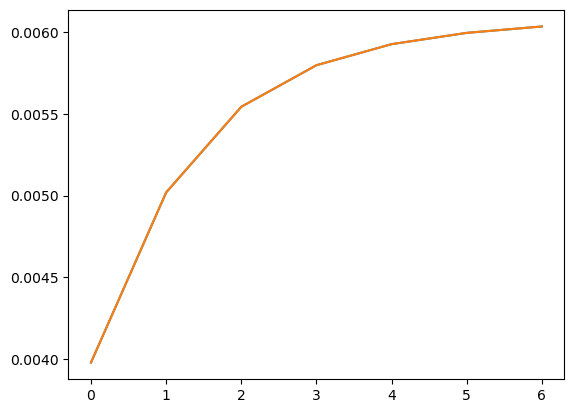

In [3]:
compare_transition_matrix(use_parallel=True)

hmmlearn
[[0.32980949 0.67019051]
 [0.08873758 0.91126242]]
correction
[[0.32980949 0.67019051]
 [0.08873758 0.91126242]]
gradient
[[0.30151214 0.69848786]
 [0.06371359 0.93628641]]
diff
[[ 7.77156117e-16 -8.88178420e-16]
 [ 4.85722573e-16 -4.44089210e-16]]


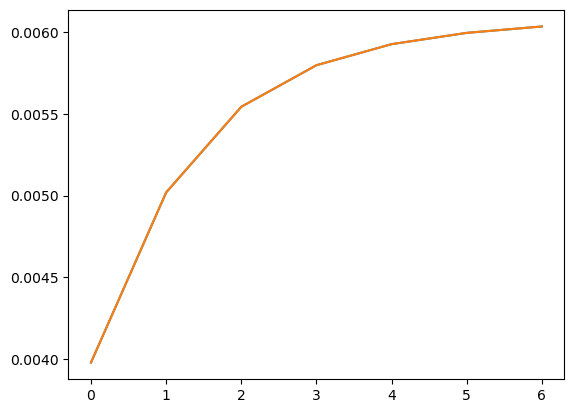

In [4]:
compare_transition_matrix(use_parallel=False)


In [5]:
compare_one()


hmmlearn
[[0.43921478 0.56078522]
 [0.21445682 0.78554318]]
parallel
[[0.43921478 0.56078522]
 [0.21445682 0.78554318]]
correction
[[0.43921478 0.56078522]
 [0.21445682 0.78554318]]
hmmlearn vs. parallel
[[ 1.11022302e-16 -1.11022302e-16]
 [ 0.00000000e+00  1.11022302e-16]]
hmmlearn vs. correction
[[ 5.55111512e-17 -2.22044605e-16]
 [ 8.32667268e-17  0.00000000e+00]]


In [6]:
# TODO:

# viterbi

In [7]:
from src.test_hmm import generate_data3
from src.hmm import estimate_transition_matrix_from_gradient_descent, get_likelihood

(
    initial_conditions,
    transition_matrix,
    emission_matrix,
    _,
    observations_ind,
) = generate_data3()

likelihood = get_likelihood(emission_matrix, observations_ind)

graident_transition_matrix, _ = estimate_transition_matrix_from_gradient_descent(
    initial_conditions, likelihood, transition_matrix
)

graident_transition_matrix

/Users/edeno/miniconda3/envs/test_hmm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:574: RuntimeWarning: overflow encountered in add
  x = x0 + h_vecs[i]


array([[9.99997244e-01, 2.75550775e-06, 5.12476017e-10],
       [0.00000000e+00, 2.80615991e-03, 9.97193840e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [8]:
graident_transition_matrix[0, 0]

0.9999972439797711

In [9]:
from src.hmm import reconstruct_transition

import numpy as np
from scipy.optimize import minimize
from scipy.special import logit, softmax

n_states = transition_matrix.shape[0]
is_off_diagonal = ~np.identity(n_states, dtype=bool)

x0 = np.nan_to_num(logit(transition_matrix[is_off_diagonal]))

transition_matrix, reconstruct_transition(x0, n_states)

(array([[0. , 0.5, 0.5],
        [0. , 0.9, 0.1],
        [0. , 0. , 1. ]]),
 array([[0.33333333, 0.33333333, 0.33333333],
        [0.        , 0.9       , 0.1       ],
        [0.        , 0.        , 1.        ]]))

In [10]:
transition_matrix[is_off_diagonal], x0

(array([0.5, 0.5, 0. , 0.1, 0. , 0. ]),
 array([ 0.00000000e+000,  0.00000000e+000, -1.79769313e+308,
        -2.19722458e+000, -1.79769313e+308, -1.79769313e+308]))

In [11]:
logit(1 - np.spacing(1))

36.04365338911715

In [12]:
blah = np.zeros((n_states, n_states))
blah[0, 1] = x0[0]
blah[0, 2] = x0[1]

blah[1, 0] = x0[2]
blah[1, 2] = x0[3]

blah[2, 0] = x0[4]
blah[2, 1] = x0[5]
blah = np.exp(blah)
blah /= blah.sum(axis=1, keepdims=True)
blah


array([[0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.9       , 0.1       ],
       [0.        , 0.        , 1.        ]])

In [13]:
x0

array([ 0.00000000e+000,  0.00000000e+000, -1.79769313e+308,
       -2.19722458e+000, -1.79769313e+308, -1.79769313e+308])

In [14]:
reconstruct_transition(transition_matrix[is_off_diagonal], n_states)

array([[0.23269654, 0.38365173, 0.38365173],
       [0.32204346, 0.32204346, 0.35591307],
       [0.33333333, 0.33333333, 0.33333333]])

In [15]:
def viterbi(initial_conditions, likelihood, transition_matrix):
    
    n_time, n_states = likelihood.shape
    
    path_prob = np.zeros_like(likelihood)
    back_pointer = np.zeros_like(likelihood, dtype=int)

    path_prob[0] = initial_conditions.copy() * likelihood[0]
    # path_prob[0] /= np.nansum(path_prob[0])
    
    for time_ind in range(1, n_time):
        prior = path_prob[time_ind - 1] * transition_matrix
        back_pointer[time_ind - 1] = np.argmax(prior, axis=1)
        path_prob[time_ind] =  np.max(prior, axis=1) * likelihood[time_ind]
        # path_prob[time_ind] /= np.nansum(path_prob[time_ind])
        
    # Find the best accumulated path prob in the last time bin
    # and then trace back the best path
    best_path = np.zeros((n_time,), dtype=int)
    best_path[-1] = np.argmax(path_prob[-1])
    for k in range(n_time - 1, -1, -1):  
        best_path[k - 1] = back_pointer[k, best_path[k]]
    
    return best_path, path_prob, back_pointer

In [16]:
best_path, path_prob, back_pointer = viterbi(initial_conditions, likelihood, transition_matrix)
best_path, path_prob, back_pointer

(array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([[0.5, 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0. , 0. ]]),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]))

In [17]:
import numpy as np


def viterbi(A, C, B, O):
    """Viterbi algorithm for solving the uncovering problem

    Notebook: C5/C5S3_Viterbi.ipynb

    Args:
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution  of dimension I
        B (np.ndarray): Output probability matrix of dimension I x K
        O (np.ndarray): Observation sequence of length N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        D (np.ndarray): Accumulated probability matrix
        E (np.ndarray): Backtracking matrix
    """
    I = A.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence

    # Initialize D and E matrices
    D = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D[:, 0] = np.multiply(C, B[:, O[0]])

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(I):
            temp_product = np.multiply(A[:, i], D[:, n-1])
            D[i, n] = np.max(temp_product) * B[i, O[n]]
            E[i, n-1] = np.argmax(temp_product)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]
        
    return S_opt, D, E


In [18]:
emission_matrix[:, observations_ind[0]].T

array([0.5, 0.9, 0.1])

In [19]:
best_path, path_prob, back_pointer = viterbi(transition_matrix, initial_conditions, emission_matrix, observations_ind)
best_path, path_prob.T, back_pointer.T

(array([0, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32),
 array([[5.00000000e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.50000000e-02, 2.25000000e-01],
        [0.00000000e+00, 2.25000000e-03, 2.02500000e-01],
        [0.00000000e+00, 1.82250000e-03, 2.02500000e-02],
        [0.00000000e+00, 1.47622500e-03, 2.02500000e-03],
        [0.00000000e+00, 1.19574225e-03, 2.02500000e-04],
        [0.00000000e+00, 1.07616803e-04, 1.82250000e-04],
        [0.00000000e+00, 8.71696100e-05, 1.82250000e-05],
        [0.00000000e+00, 7.84526490e-06, 1.64025000e-05]]),
 array([[0, 0, 0],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]], dtype=int32))

In [20]:
path_prob.T[0]

array([0.5, 0. , 0. ])

In [33]:
from src.hmm import viterbi

# Define model parameters
transition_matrix = np.array([[0.8, 0.1, 0.1], 
              [0.2, 0.7, 0.1], 
              [0.1, 0.3, 0.6]])

initial_conditions = np.array([0.6, 0.2, 0.2])

emission_matrix = np.array([[0.7, 0.0, 0.3], 
              [0.1, 0.9, 0.0], 
              [0.0, 0.2, 0.8]])


observations_ind = np.array([0, 2, 0, 2, 2, 1]).astype(np.int32)

likelihood = get_likelihood(emission_matrix, observations_ind)

viterbi(initial_conditions, likelihood, transition_matrix)

TypeError: viterbi() missing 1 required positional argument: 'O'

In [ ]:
likelihood 

In [ ]:
transition_matrix[is_off_diagonal]

In [ ]:
transition_matrix

In [ ]:
n_time, n_states = likelihood.shape

path_prob = np.zeros_like(likelihood)
back_pointer = np.zeros_like(likelihood, dtype=int)

path_prob[0] = initial_conditions.copy() * likelihood[0]

In [ ]:
time_ind = 1

prior = path_prob[time_ind - 1] * transition_matrix
np.argmax(prior, axis=1)

In [ ]:
path_prob[time_ind - 1] * transition_matrix

In [32]:
spikes = np.zeros((3, 2))
spikes[0, 1] = 1
spikes[1, 0] = 1

dt = 1 / 500

prob = np.ones((3, 1))

(spikes * prob) / prob.sum(axis=0) / dt

array([[  0.        , 166.66666667],
       [166.66666667,   0.        ],
       [  0.        ,   0.        ]])